In [334]:
import requests
from contextlib import closing
import csv
import codecs
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import datetime 
from datetime import timedelta 
import seaborn as sns
import plotly.figure_factory as ff # map of the US
import plotly.graph_objects as go
import import_ipynb
from utils_common import *

In [335]:
# Where Department of Labor keep all its precious data...
# https://oui.doleta.gov/unemploy/DataDownloads.asp
_DOL_DATA_PATH_ = 'https://oui.doleta.gov/unemploy/csv/'

# ETA 539: Weekly Claims and Extended Benefits Trigger Data

# General description: The claims data contained on the ETA 539 report are used 
# in current economic analysis of unemployment trends in the Nation, and in each state. 
# Initial claims measure emerging unemployment and continued weeks claimed measure 
# the number of the insured unemployed. 
# These data are published in ETA´s weekly release "Unemployment Insurance Claims." 
# The comments on claims activity are used to explain the changes in the levels of the data reported from week to week.

name_539 = 'ar539.csv'

_State_PATH_ = './data_US/data_NYT_state.csv'

# Where to save the dataframes and figures
_Data_PATH_ = './data_US/data_dol/'
_Figure_PATH_ = './figures_US/figures_dol/'

In [336]:
# colunm name dictioary
# most important: IC and CW
# Initial claims measure emerging unemployment and 
# continued weeks claimed measure the number of the insured unemployed.
# These data are published in ETA's weekly release "Unemployment Insurance Claims."
# They are particularly important when there are significant rises or declines 
# in either initial claims or continued weeks claimed counts.
rename_dict = {'st': 'state_name_ab', # STATE
               'rptdate': 'report_date', # REPORT FOR PERIOD ENDING # Filed week ended
               'c1': 'week_number', # Week Number
               'c2': 'reflect_date', # Reflected Week Ending # Reflecting Week Ende
               'c3': 'IC', # initial_claims # State UI Initial Claims, less intrastate transitionals # Initial Claims
               'c4': 'FIC', # federal_initial_claims # UCFE-no UI Initial Claims # Unemployment Compensation for Federal Employees
               'c5': 'XIC', # UCX only Initial Claims # Unemployment Compensation for Ex-servicemembers
               'c6': 'WSIC', # STC or workshare total initial claims # Short-Time Compensation
               'c7': 'WSEIC', # STC or workshare equivalent initial claims
               'c8': 'CW', # State UI adjusted continued weeks claimed # Continued Claims # Insured Unemployment
               'c9': 'FCW', # UCFE-no UI adjusted continued weeks claimed
               'c10': 'XCW', # UCX only adjusted continued weeks claimed
               'c11': 'WSCW', # STC or workshare total continued weeks claimed
               'c12': 'WSECW', # STC or workshare equivalent continued weeks claimed
               'c13': 'EBT', #  Total continued weeks claimed under the Federal/State Extended Benefit Program: 
                             # includes all intrastate and interstate continued weeks claimed filed from an agent state under the state UI, UCFE and UCX programs.
               'c14': 'EBUI', # That part of EBT which represents only state UI weeks claimed under the Federal/State EB program. 
               'c15': 'ABT', # Total continued weeks claimed under a state additional benefit program for those states which have such a program(Includes UCFE and UCX).
               'c16': 'ABUI', # That part of ABT which represents only state UI additional continued weeks claimed for those states which have such a program.
               'c17': 'AT', # Average adjusted Total Continued Weeks Claimed
               'c18': 'CE', # Covered Employment # Covered Employment
               'c19': 'R', # Rate of Insured Unemployment
               'c20': 'AR', # Average Rate of Insured Unemployment in Prior Two Years
               'c21': 'P', # Current Rate as Percent of Average Rate in Prior Two Years
               'c22': 'status', # STATUS # B or E # Indicate the beginning (B) or ending (E) of a state extended benefit period.
               'c23': 'status_change_date', 
               'curdate': 'current_date', 
               'priorwk_pub': 'prior_week_pub_date', 
               'priorwk': 'prior_week_date'} # STATUS CHANGE DATE # If Status has changed since the prior week, enter the date the change is effective.

# new column names from https://oui.doleta.gov/unemploy/wkclaims/report.asp

In [337]:
def load_weekly_claims_raw(name):
    url = _DOL_DATA_PATH_ + name
    df = pd.read_csv(url, low_memory = False)
    df = df.rename(columns = rename_dict)
    df['state_name'] = df.apply(lambda row: [k for k,v in names_state_short_dict.items() if v == row.state_name_ab][0], axis = 1)
    # new column from https://oui.doleta.gov/unemploy/wkclaims/report.asp
    # Insured Unemployment Rate = Continued Claims/Covered Employment
    df['current_R'] = df.apply(lambda row: round(row.CW/row.CE*100, 2), axis = 1)
    columns = df.columns.values
    columns_date = [item for item in columns if 'date' in item]
    for col in columns_date:
        df[col] = pd.to_datetime(df[col])
        df[col] = df[col].dt.date

    new_columns = ['state_name', 'state_name_ab', 'report_date', 'reflect_date', 'week_number', 
                  'IC', 'FIC', 'XIC', 'WSIC', 'WSEIC', 'CW', 'FCW', 'XCW', 'WSCW',
                   'WSECW', 'EBT', 'EBUI', 'ABT', 'ABUI', 'AT', 'CE', 'current_R', 'R', 'AR', 'P',
                   'status', 'status_change_date', 'current_date',
                   'prior_week_pub_date', 'prior_week_date']
    df = df[new_columns]
    
    df = df.sort_values(by = ['report_date', 'state_name'])
    df = df.reset_index(drop = True)

    new_columns_sub = ['state_name', 'state_name_ab', 'report_date', 'reflect_date',  'IC', 'CW', 'CE', 'current_R']
    df_sub = df[new_columns_sub]
    rename_dict_sub = {'IC': 'initial_claims', 'CW': 'continued_claims', 'CE': 'covered_employment', 'current_R': 'insured_unemployment_rate'}
    df_sub = df_sub.rename(columns = rename_dict_sub)
    
    return df, df_sub

def load_NYT_raw():
    raw_state = pd.read_csv(_State_PATH_) 
    raw_state['update_date'] = pd.to_datetime(raw_state['update_date'])
    raw_state['update_date'] = raw_state['update_date'].dt.date
    return raw_state

# four-week average
def add_rolling(df):
    names_region = list(set(df['state_name']))
    names_region.sort()
    df_new = []
    for i, name in enumerate(names_region):
        df_single = df[df['state_name'] == name]
        df_single = df_single.sort_values(by = 'report_date')
        df_single = df_single.reset_index(drop = True)
        columns = ['initial_claims', 'continued_claims', 'covered_employment']
        for j, col in enumerate(columns): # 'sa' stands for seasonally adjusted
            df_single[col] = df_single[col].rolling(4).mean()   
        col = 'insured_unemployment_rate'
        df_single[col] = df_single.apply(
            lambda row: round(row.continued_claims/row.covered_employment*100, 2), axis = 1)
        df_new.append(df_single)
    df_new = pd.concat(df_new)  
    df_new = df_new.sort_values(by = ['report_date', 'state_name'])
    df_new = df_new.reset_index(drop = True)
    return df_new

# change: difference and percentage change
def add_diff(df, pd_diff = 1, pd_pct_change = 1):
    names_region = list(set(df['state_name']))
    names_region.sort()
    for i, name in enumerate(names_region):
        df_single = df[df['state_name'] == name]
        df_single = df_single.sort_values(by = 'report_date')
        df_single = df_single.reset_index(drop = True)
        columns = ['initial_claims', 'continued_claims', 'covered_employment', 'insured_unemployment_rate']
        for j, col in enumerate(columns): # 'diff' stands for difference # 'ratio' stands for ratio
            df_single[col + '_diff'] = df_single[col].diff(periods = pd_diff)
        for j, col in enumerate(columns):
            df_single[col + '_pct_change'] = round(df_single[col].pct_change(periods = pd_pct_change)*100, 2)
        
        df_new.append(df_single) 
    
    df_new = pd.concat(df_new)  
    df_new = df_new.sort_values(by = ['report_date', 'state_name'])
    df_new = df_new.reset_index(drop = True)
    return df_new

In [338]:
data_dol_o, data_dol = load_weekly_claims_raw(name_539)

In [339]:
data_dol_rolling = add_rolling(data_dol)

In [340]:
data_dol[data_dol['state_name'] == 'New Hampshire'].tail()

,state_name,state_name_ab,report_date,reflect_date,initial_claims,continued_claims,covered_employment,insured_unemployment_rate
94401,New Hampshire,NH,2020-03-21,2020-03-14,29372,4020,654468,0.61
94454,New Hampshire,NH,2020-03-28,2020-03-21,31374,27304,654468,4.17
94507,New Hampshire,NH,2020-04-04,2020-03-28,39187,52146,654468,7.97
94560,New Hampshire,NH,2020-04-11,2020-04-04,25236,79927,649845,12.30
94613,New Hampshire,NH,2020-04-18,2020-04-11,20401,93698,649845,14.42


In [341]:
data_dol_rolling[data_dol_rolling['state_name'] == 'New Hampshire'].tail(6)

,state_name,state_name_ab,report_date,reflect_date,initial_claims,continued_claims,covered_employment,insured_unemployment_rate
94348,New Hampshire,NH,2020-03-14,2020-03-07,618.25,4088.00,654468.00,0.62
94401,New Hampshire,NH,2020-03-21,2020-03-14,7850.25,4110.00,654468.00,0.63
94454,New Hampshire,NH,2020-03-28,2020-03-21,15470.25,9925.00,654468.00,1.52
94507,New Hampshire,NH,2020-04-04,2020-03-28,25143.25,21843.75,654468.00,3.34
94560,New Hampshire,NH,2020-04-11,2020-04-04,31292.25,40849.25,653312.25,6.25
94613,New Hampshire,NH,2020-04-18,2020-04-11,29049.50,63268.75,652156.50,9.70


In [299]:
#data_dol = add_change(data_dol)
#data_dol_rolling = add_change(data_dol_rolling)

In [342]:
data_state = load_NYT_raw()
date_initial = min(data_state['update_date'])

In [343]:
# Plot the confirmed cases for every state
def figure_correlation(df, df_dol, names_state, subject = 'insured_unemployment_rate', fsize = (5,3), ncol = 4, ms = 2, fs = 10, logy = False, 
                    title = None, country = 'US', pvi = False):
    
    sns.set_style("ticks")
    
    m = len(names_state)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (2*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
            
    for i, state in enumerate(names_state):
        
        if pvi == True:
            c = color_pvi(df_state_pvi, state)
        else:
            c = palette(i/100 + 0.2)
        
        ix = np.unravel_index(i, axes.shape)
        
        plot_df = df[df['state_name'] == state]
        
        axes[ix].plot(plot_df['update_date'], plot_df['cum_confirmed'],
                linewidth = 2, marker = 'o', ms = ms, color = c, label = (lambda x: None if x > 0 else 'infection')(i)) # 
        
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel('Date', fontsize = fs - 2)
            
        if i % ncol == 0:
            axes[ix].set_ylabel('Number of people (cum)', fontsize = fs - 2)
        if i == 0:
            axes[ix].legend(loc = 'upper left', fancybox = True, fontsize = fs - 4)
        
        axes[ix].set_title(state, fontsize = fs)
        
        
    fig.align_ylabels(axes[:, 0])
    
    for i, state in enumerate(names_state):   
        if pvi == True:
            c = color_pvi(df_state_pvi, state)
        else:
            c = palette(i/100 + 0.2)
        ix = np.unravel_index(i, axes.shape)
        plot_df = df_dol[df_dol['state_name'] == state]
        plot_df = plot_df[plot_df['report_date'] >= min(df[df['state_name'] == state]['update_date'])]
        ax11 = axes[ix].twinx()
        
        #ax11.grid(False) # hide grid lines
        if subject == 'insured_unemployment_rate':
            ax11.bar(plot_df['report_date'], height = plot_df[subject], width = 2, color = c, alpha = 0.8,
                    label = (lambda x: None if x > 0 else 'unemployment')(i))
        elif subject == 'initial_claims':
            ax11.bar(plot_df['report_date'], height = plot_df[subject]/1e3, width = 2, color = c, alpha = 0.8,
                    label = (lambda x: None if x > 0 else 'unemployment')(i))
        else:
            plot_df = plot_df[plot_df['reflect_date'] >= min(df[df['state_name'] == state]['update_date'])]
            ax11.bar(plot_df['reflect_date'], height = plot_df[subject]/1e3, width = 2, color = c, alpha = 0.8,
                    label = (lambda x: None if x > 0 else 'unemployment')(i))
        daily_patch = mpatches.Patch(color = c, label = subject.replace("_", " "))
        if i == 0:
            ax11.legend(handles=[daily_patch], loc='upper left', bbox_to_anchor=(0, 0.86), fancybox=True, fontsize = fs - 4)
        ax11.tick_params(axis = 'y', which = 'major', labelsize = fs - 4)
        ax11.tick_params(axis = 'y', which = 'minor', labelsize = fs - 4)
        
        ax11.get_yaxis().set_label_coords(1.1, 0.5)
        
        if i % ncol == ncol - 1:
            if subject == 'insured_unemployment_rate':
                ax11.set_ylabel('Rate', fontsize = fs - 2)
            else:
                ax11.set_ylabel('Number (unit = 1,000)', fontsize = fs - 2)
        axes[ix].set_xlim(min(df.update_date), max(df.update_date))
        axes[ix].xaxis.set_major_locator(mdates.DayLocator((1,15)))
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
    
    if subject == 'continued_claims':
        subject = 'insured_unemployment'
        
    fig.suptitle(title + ' (' + subject.replace("_", " ") + ')', fontsize = fs + 4, y = 0.915)
    
    if pvi == True:
        
        ix = np.unravel_index(int(ncol/2), axes.shape)
        palette_D = plt.get_cmap('Blues')
        palette_R = plt.get_cmap('Reds')
        palette_Even = plt.get_cmap('Greens')
        palette_None = plt.get_cmap('Purples')
        patch_D = mpatches.Patch(color = palette_D(0.6), label = 'Democratic')
        patch_R = mpatches.Patch(color = palette_R(0.6), label = 'Republican')
        patch_Even = mpatches.Patch(color = palette_Even(0.6), label = 'Even')
        patch_None = mpatches.Patch(color = palette_None(0.6), label = 'None')

        axes[ix].legend(handles = [patch_D, patch_R, patch_Even], loc = 'upper left', 
                   ncol = 4, bbox_to_anchor=(-0.65, 1.55), fontsize = fs, fancybox=True)
    

    fig.savefig(_Figure_PATH_ + country + '_' + subject + '.png', dpi = 400, bbox_inches='tight')

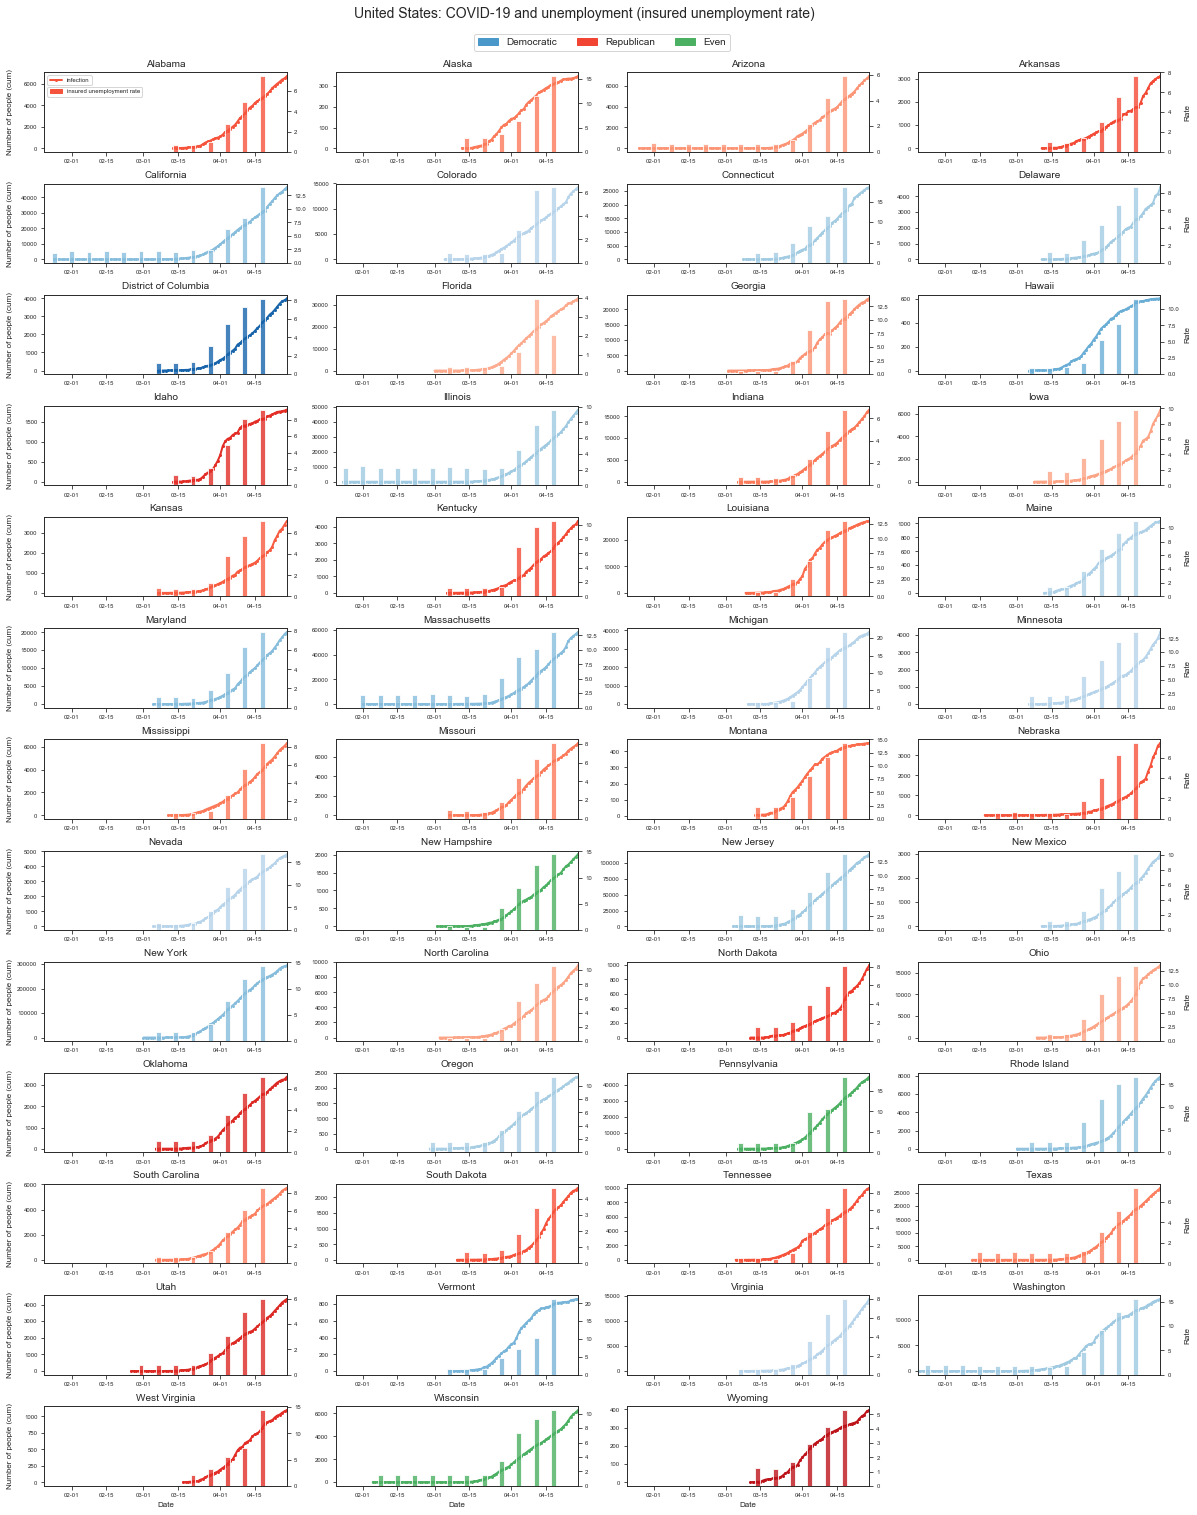

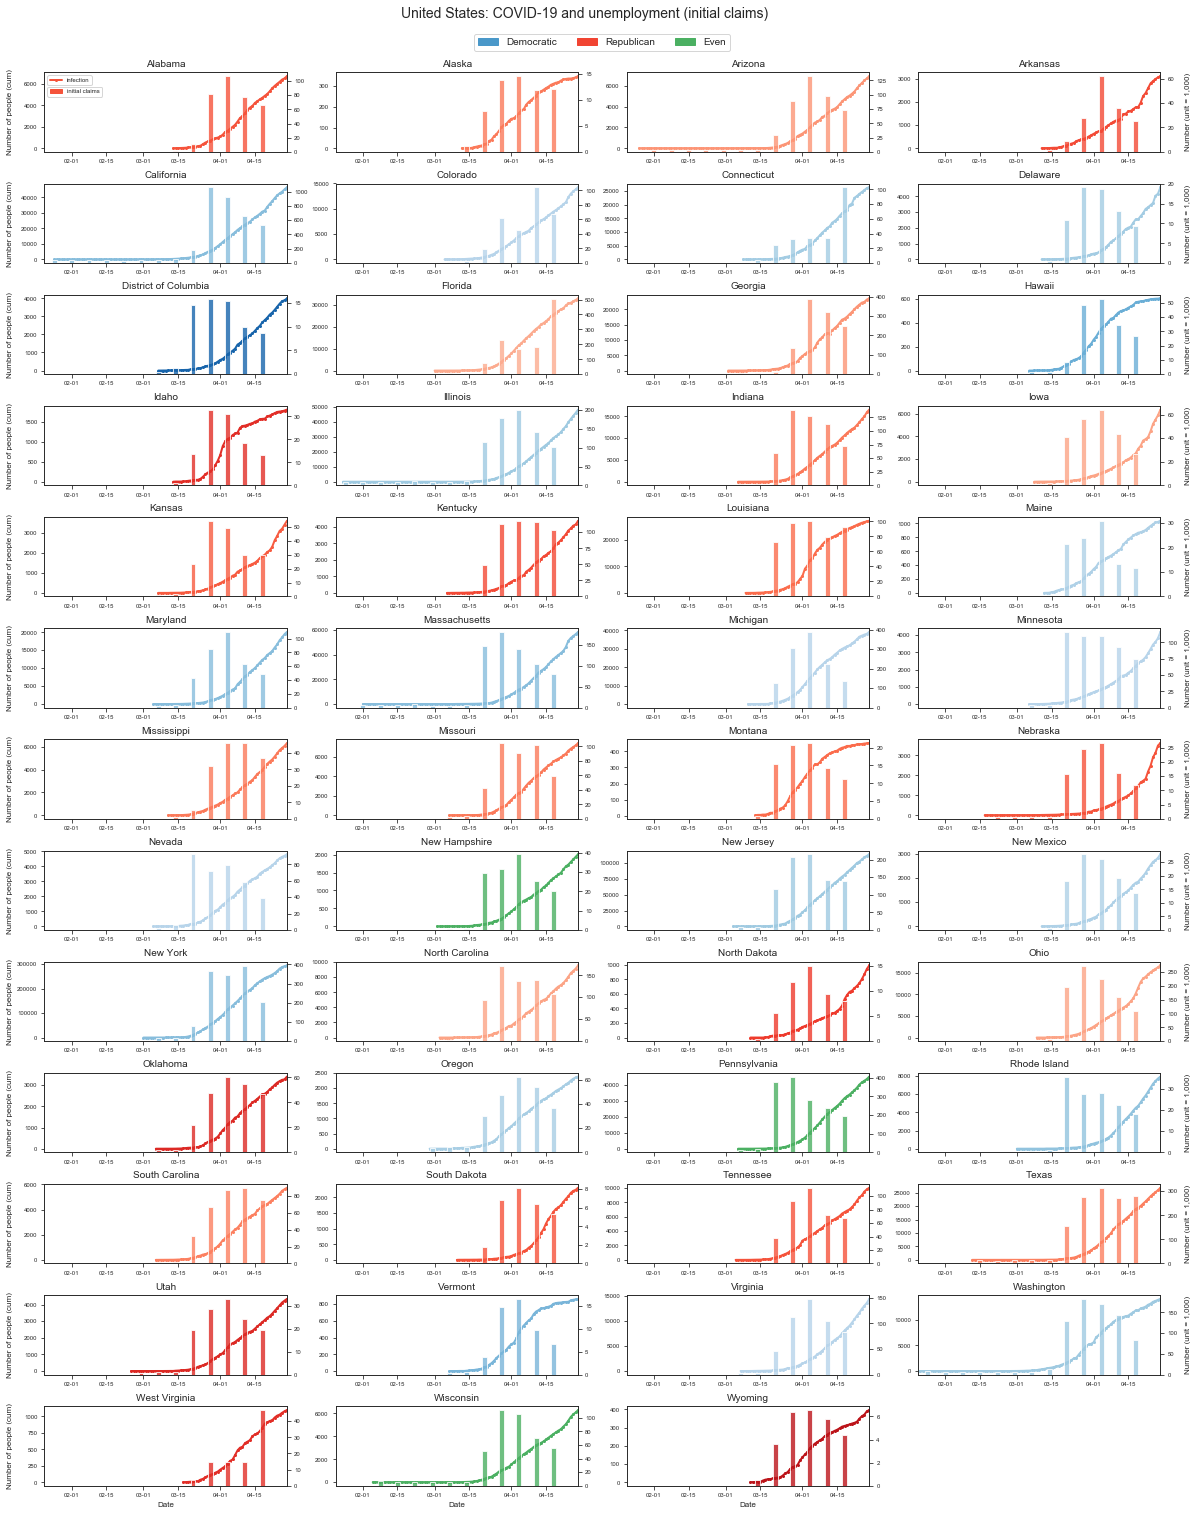

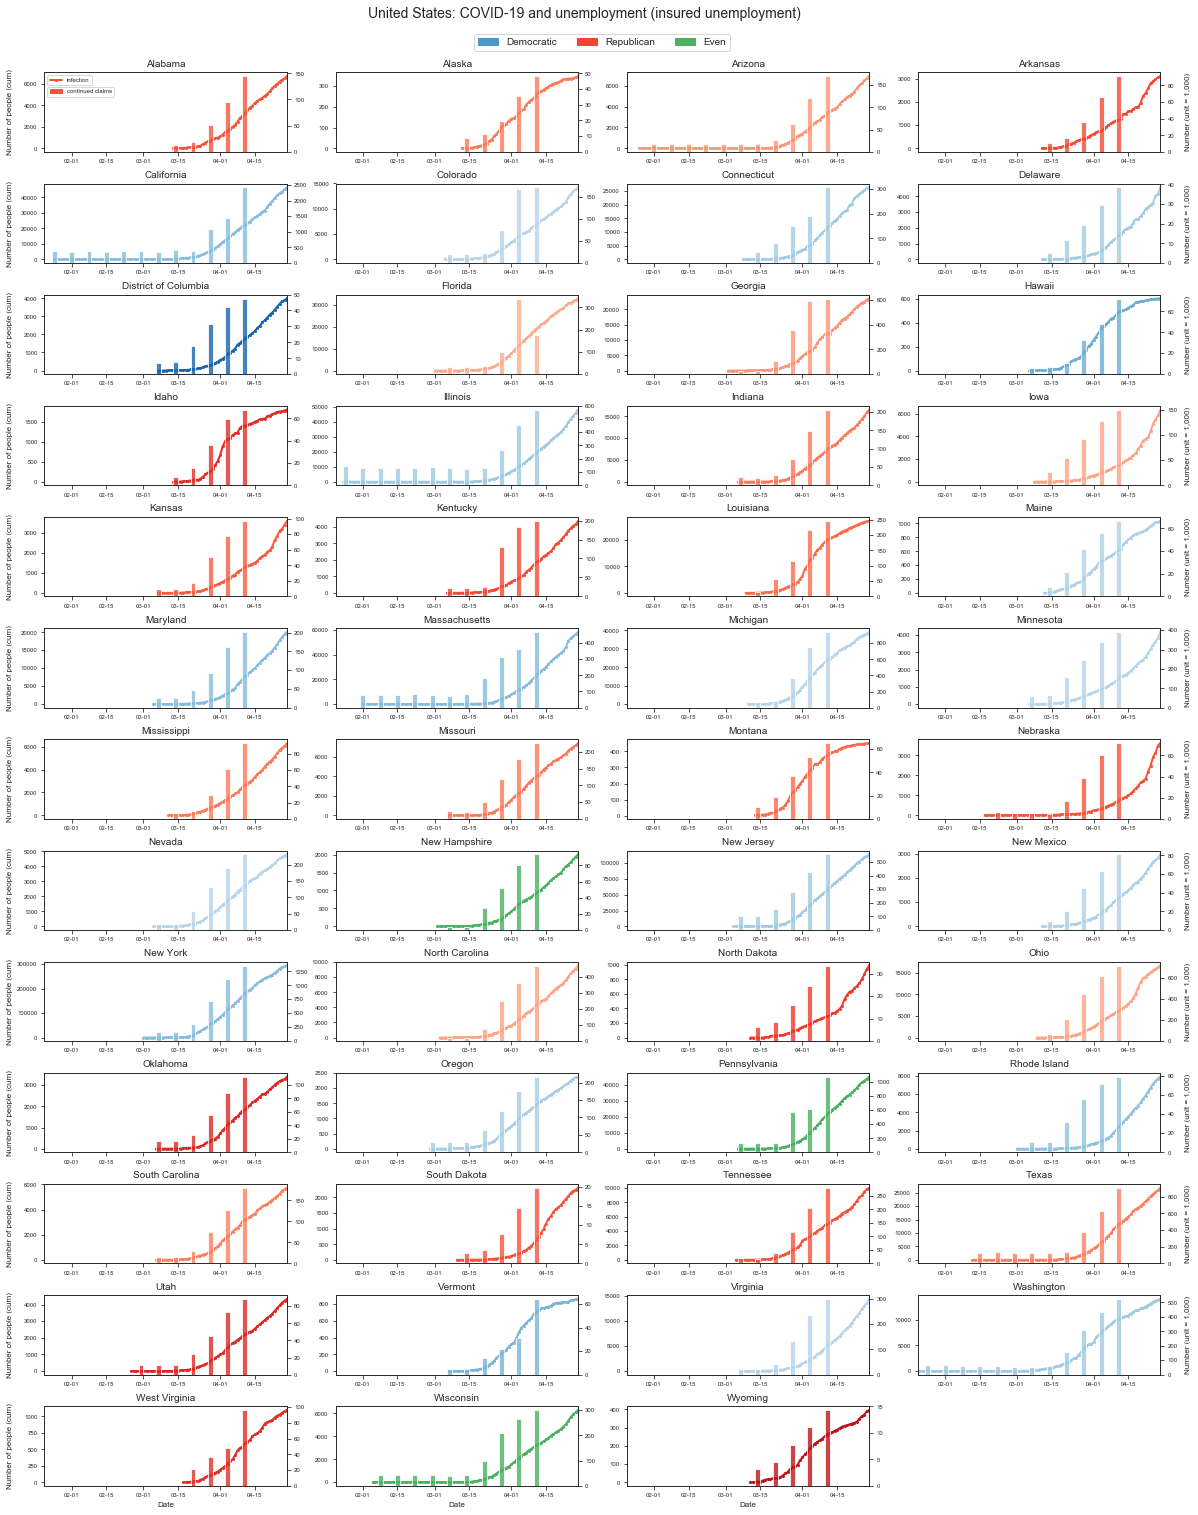

In [345]:
subject_list = ['insured_unemployment_rate', 'initial_claims', 'continued_claims']
figure_correlation(df = data_state, df_dol = data_dol[data_dol['report_date'] >= date_initial], names_state = names_state, fsize = (10, 2), 
                   subject = subject_list[0], ncol = 4, ms = 2, fs = 10, logy = False, 
                   title = 'United States: COVID-19 and unemployment', country = 'US', pvi = True)
figure_correlation(df = data_state, df_dol = data_dol[data_dol['report_date'] >= date_initial], names_state = names_state, fsize = (10, 2), 
                   subject = subject_list[1], ncol = 4, ms = 2, fs = 10, logy = False, 
                   title = 'United States: COVID-19 and unemployment', country = 'US', pvi = True)
figure_correlation(df = data_state, df_dol = data_dol[data_dol['report_date'] >= date_initial], names_state = names_state, fsize = (10, 2), 
                   subject = subject_list[2], ncol = 4, ms = 2, fs = 10, logy = False, 
                   title = 'United States: COVID-19 and unemployment', country = 'US', pvi = True)

In [349]:
# State level map
def figure_map_dol(df, update_date_tr, subject = 'insured_unemployment_rate', title = None, country = 'US', cmap = 'Reds'):
    df = df.copy()
    df = df[df['state_name'].isin(names_state)]
    data_single = df[df['report_date'] == update_date_tr]
    locations = [names_state_short_dict[name] for name in names_state]
    values = [data_single[data_single['state_name'] == item][subject].tolist()[0] for item in names_state]
    if subject == 'insured_unemployment_rate': 
        fig = go.Figure(data = go.Choropleth(
            locations = locations, # Spatial coordinates
            z = values, # Data to be color-coded
            locationmode = 'USA-states', # set of locations match entries in `locations`
            colorscale = cmap,             
            marker_line_color = 'white',
            colorbar_title = "rate",
        ))
        fig.update_layout(
        title_text = title + '<br>' + 'Week ended: ' + update_date_tr.strftime("%d %B, %Y") + 
        '<br>' + subject.replace("_", " ").capitalize(),
        geo = dict(
            scope = 'usa',
            projection = go.layout.geo.Projection(type = 'albers usa'),
            showlakes = True, # lakes
            lakecolor='rgb(255, 255, 255)'),
        )
    else: # log scale
        values_log = [np.log10(temp) for temp in values]
        ticks = [np.power(10, i) for i in np.linspace(4, 8, 5)]
        def formatting(n):
            if n < 1e6:
                return str(int(n/1e3)) + 'k'
            else:
                return str(int(n/1e6)) + 'm'
        fig = go.Figure(data = go.Choropleth(
        locations = locations, # Spatial coordinates
        z = values_log, 
        locationmode = 'USA-states', 
        colorscale = cmap,
        marker_line_color = 'white',
        colorbar_title = "number",
        colorbar = dict(
        tickvals = [np.log10(item) for item in ticks],
        ticktext = [formatting(item) for item in ticks],)
        ))
        if subject == 'continued_claims':
            update_date_tr -= timedelta(days=7)
            subject = 'insured_unemployment'
        fig.update_layout(
        title_text = title + '<br>' + 'Week ended: ' + update_date_tr.strftime("%d %B, %Y") + 
        '<br>' + subject.replace("_", " ").capitalize() + ': ' + str(np.sum(values)),
        geo = dict(
            scope = 'usa',
            projection = go.layout.geo.Projection(type = 'albers usa'),
            showlakes = True, # lakes
            lakecolor='rgb(255, 255, 255)'),
        )

    fig.show()
    fig.write_image(_Figure_PATH_ + country + '_' + subject + '_map.png')

In [360]:
df = data_dol[data_dol['report_date'] >= date_initial].copy()
df = df[df['state_name'].isin(names_state)]
data_single = df[df['report_date'] == date_tr]
locations = [names_state_short_dict[name] for name in names_state]
values = [data_single[data_single['state_name'] == item]['insured_unemployment_rate'].tolist()[0] for item in names_state]

In [365]:
# in case plotly cannot communicate with orca
# run the following command on terminal
#/Users/xingruchen/anaconda3/bin/orca serve -p 58823 --plotly 
#/Users/xingruchen/anaconda3/lib/python3.7/site-packages/plotly/package_data/plotly.min.js --graph-only --mathjax https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js
date_tr = max(data_dol['report_date'])
figure_map_dol(data_dol[data_dol['report_date'] >= date_initial], date_tr, subject = 'insured_unemployment_rate',
               title = 'United States', country = 'US', cmap = 'tealrose')

In [366]:
figure_map_dol(data_dol[data_dol['report_date'] >= date_initial], date_tr, subject = 'initial_claims',
               title = 'United States', country = 'US', cmap = 'tealrose')

In [367]:
date_tr = max(data_dol['report_date'])
figure_map_dol(data_dol, date_tr, subject = 'continued_claims',
               title = 'United States', country = 'US', cmap = 'tealrose')